This notebook is used to improve the salinity of the deep water at the model's western boundary.

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import datetime

from salishsea_tools import nc_tools
from salishsea_tools.nowcast import analyze, figures
%matplotlib inline

# Background

The notebook below found some discrepancies between the model's western boundary condition, based on climatological values of the Masson BC coast mode, and observed values. 

http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/analysis/raw/tip/Nancy/strat/comparisons/Another%20look%20at%20JDF%20BCS.ipynb

Based on this analysis, we propose a correction to the deep salinity of the open boundary. For each time, we apply the followin correction

$S_{new}(t) = S_{old}(t) + ( mean(S_{obs}) - mean(S_{old}) )*1/2(1+\tanh((z-150)/50))$

where the mean represents an average of all the depth-averaged data points in a a month. The monthly means were interpolated onto weekly model forcing times. Depth-averaging is performed over depths 150m and lower.

That is

$mean(S_{obs}) = 1/N\sum^N  < S_{obs}>_{150m}$

where $<>_{150m}$ means depth-averged below 150m, and $N$ is the number of data points in that month.

First, copy the boundary conditions file

In [2]:
! cp /data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea2_Masson_DC.nc SalishSea2_Masson_corrected.nc

F = nc.Dataset('SalishSea2_Masson_corrected.nc', 'r+')



In [3]:
sal = F.variables['vosaline']
deps = F.variables['deptht']    
time = F.variables['time_counter']

#times convert to date time
start = datetime.datetime(2014,1,1) #arbitrary year.
dates = [ start + datetime.timedelta(days = 7*t) for t in time]

print(sal.shape)

(52, 40, 1, 870)


# Corrections

a. Construct hyperbolic tanh

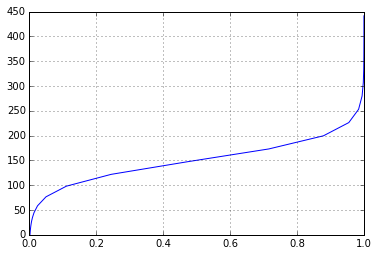

In [4]:
tanh = 1./2.*(1+np.tanh((deps[:]-150)/50.))
plt.plot(tanh,deps)
plt.grid()

In [5]:
tanh = np.expand_dims(tanh,0)
tanh = np.expand_dims(tanh,2)
tanh = np.expand_dims(tanh,3)
print(tanh.shape)

(1, 40, 1, 1)


b. Construct monthly correction

This is from the notebook and was copied by hand.

In [6]:
corr = [-0.03356964,  0.3367368,   0.52041384,  0.39891783,  0.41826563,  0.35967722,
       0.27993952,  0.27747043,  0.19912566,  0.22870407,  0.21248102, -0.08515805]

c. Interpolate onto weeks

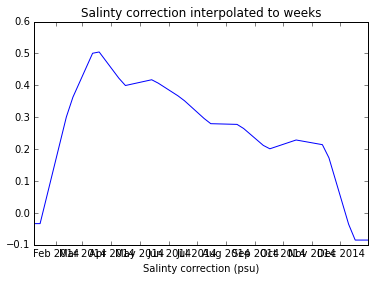

In [7]:
month_dates = [datetime.datetime(2014,m,15) for m in np.arange(1,13)]

corr_weekly = figures.interp_to_model_time(dates, corr, month_dates)

plt.plot(dates, corr_weekly)
plt.xlabel('Salinty correction (psu)')
plt.title('Salinty correction interpolated to weeks')

# Apply correction, month by month

In [8]:
months = np.arange(1,13)
salold = np.copy(sal)
for t in np.arange(salold.shape[0]):
    sal[t,:,:,:] = salold[t,:,:,:] + corr_weekly[t]*tanh

# Visualize

Colormap over depth and time. First grid point.

/home/nsoontie/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


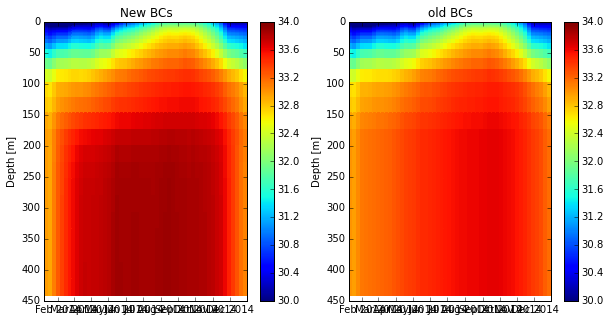

In [9]:
i=0
j=0
fig,axs = plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
mesh = ax.pcolormesh(np.array(dates), deps[:], sal[:,:,j,i].T,vmin=30,vmax=34)
ax.invert_yaxis()
plt.colorbar(mesh, ax=ax)
ax.set_title('New BCs')
ax.set_ylabel('Depth [m]')
ax=axs[1]
mesh = ax.pcolormesh(np.array(dates), deps[:], salold[:,:,j,i].T,vmin=30,vmax=34)
ax.invert_yaxis()
plt.colorbar(mesh, ax=ax)
ax.set_title('old BCs')
ax.set_ylabel('Depth [m]')

### Time series comparison at depth

150m

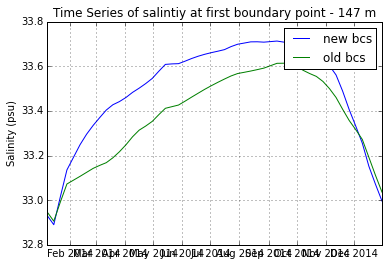

In [10]:
k=28
i=0
j=0
plt.plot(np.array(dates),sal[:,k,j,i],label = 'new bcs')
plt.plot(np.array(dates), salold[:,k,j,i], label='old bcs')
plt.legend()
plt.grid()
plt.ylabel('Salinity (psu)')
plt.title('Time Series of salintiy at first boundary point - {0:.3g} m'.format(deps[k]))

200m

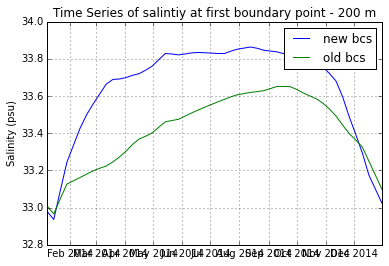

In [11]:
k=30
i=0
j=0
plt.plot(np.array(dates),sal[:,k,j,i],label = 'new bcs')
plt.plot(np.array(dates), salold[:,k,j,i], label='old bcs')
plt.legend()
plt.grid()
plt.ylabel('Salinity (psu)')
plt.title('Time Series of salintiy at first boundary point - {0:.3g} m'.format(deps[k]))

100m

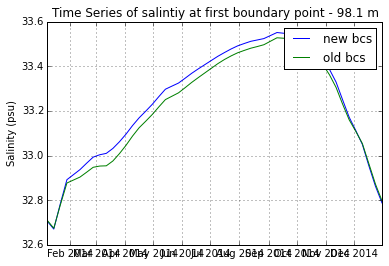

In [12]:
k=26
i=0
j=0
plt.plot(np.array(dates),sal[:,k,j,i],label = 'new bcs')
plt.plot(np.array(dates), salold[:,k,j,i], label='old bcs')
plt.legend()
plt.grid()
plt.ylabel('Salinity (psu)')
plt.title('Time Series of salintiy at first boundary point - {0:.3g} m'.format(deps[k]))

44.5m

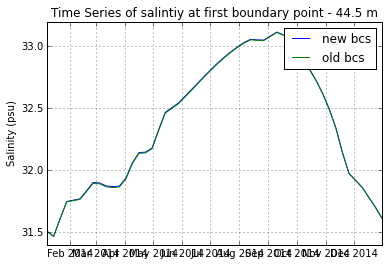

In [13]:
k=23
i=0
j=0
plt.plot(np.array(dates),sal[:,k,j,i],label = 'new bcs')
plt.plot(np.array(dates), salold[:,k,j,i], label='old bcs')
plt.legend()
plt.grid()
plt.ylabel('Salinity (psu)')
plt.title('Time Series of salintiy at first boundary point - {0:.3g} m'.format(deps[k]))

# Saving

In [14]:

nc_tools.show_dataset_attrs(F)

file format: NETCDF4
Conventions: CF-1.6
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
comment: T & S data from Masson
NCO: 4.0.9
title: 
Weekly climatology boundary conditions from Masson, depth corrected

source: 
https://bitbucket.org/salishsea/tools/src/tip/I_ForcingFiles/OBC/MakeTSfromMasson.ipynb
https://bitbucket.org/salishsea/tools/src/tip/I_ForcingFiles/OBC/MassonClimatology.ipynb
https://bitbucket.org/salishsea/tools/src/tip/I_ForcingFiles/OBC/MassonClimDC.ipynb


references: 
https://bitbucket.org/salishsea/nemo-forcing/src/tip/open_boundaries/west/SalishSea2_Masson_DC.nc

history: 
2014-01-03 13:15:17] Created netCDF4 zlib=True dataset.
Sat Jan  4 13:05:15 2014: ncks -4 -L1 -d time_counter,0,51 SalishSea_TS_Masson.nc SalishSea_Masson_trunc.nc
[2014-01-04 14:17] Formed weekly climatology from original SalishSea grided results
[2014-01-24 ] Removed Nan's
[2014-01-25 18:01 ] Corrected for partial cells




In [15]:
F.title = """
Modified boundary conditions based on weekly climatolgy from Diane Masson
"""
F.source = """
https://bitbucket.org/salishsea/tools/src/tip/I_ForcingFiles/OBC/Improved TS Climatology Western Boundary.ipynb
https://bitbucket.org/salishsea/analysys/src/tip/Nancy/strat/comparisons/JuandeFucaBCs.ipynb
"""

F.comment = """
Deep salinity (below 150m) increased by a weekly factor for a better match with observed climatologies.
""" 
F.references = """
https://bitbucket.org/salishsea/nemo-forcing/src/tip/open_boundaries/west/SalishSea2_Masson_corrected.nc
"""
F.history = """
2014-01-03 13:15:17] Created netCDF4 zlib=True dataset.
Sat Jan  4 13:05:15 2014: ncks -4 -L1 -d time_counter,0,51 SalishSea_TS_Masson.nc SalishSea_Masson_trunc.nc
[2014-01-04 14:17] Formed weekly climatology from original SalishSea grided results
[2014-01-24 ] Removed Nan's
[2014-01-25 18:01 ] Corrected for partial cells
[2015-10-19 ] Applied correction to increase deep salinity
"""
nc_tools.show_dataset_attrs(F)
 

file format: NETCDF4
Conventions: CF-1.6
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
comment: 
Deep salinity (below 150m) increased by a weekly factor for a better match with observed climatologies.

NCO: 4.0.9
title: 
Modified boundary conditions based on weekly climatolgy from Diane Masson

source: 
https://bitbucket.org/salishsea/tools/src/tip/I_ForcingFiles/OBC/Improved TS Climatology Western Boundary.ipynb
https://bitbucket.org/salishsea/analysys/src/tip/Nancy/strat/comparisons/JuandeFucaBCs.ipynb

references: 
https://bitbucket.org/salishsea/nemo-forcing/src/tip/open_boundaries/west/SalishSea2_Masson_corrected.nc

history: 
2014-01-03 13:15:17] Created netCDF4 zlib=True dataset.
Sat Jan  4 13:05:15 2014: ncks -4 -L1 -d time_counter,0,51 SalishSea_TS_Masson.nc SalishSea_Masson_trunc.nc
[2014-01-04 14:17] Formed weekly climatology from original SalishSea grided results
[2014-01-24 ] Removed Nan's
[2014-01-25 18:01 ] Corrected for partial

In [16]:
F.close()